## Pense como um Cientista de Dados
### Modelos de Árvore e Otimização Bayesiana para Classificação Binária: Casos Práticos no Mundo dos Negócios

### <font color = 'blue'>Capítulo 7. Aplicando a Otimização Bayesiana na Detecção de Fraudes</font>

# Modelo 3 - Credit Fraud Otimização Bayseana

```{python}
%load_ext watermark
%watermark -v -p numpy,pandas,scikit-learn,xgboost -u -n -t -z

Last updated: Thu Sep 26 2024 19:05:05-03

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

numpy       : 1.26.4
pandas      : 2.2.2
scikit-learn: 1.4.2
xgboost     : 2.1.1
```

In [1]:
import numpy as np, pandas as pd, os, gc, re, shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from typing import Tuple, Any
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score, make_scorer,
                             confusion_matrix, roc_curve, auc, precision_recall_curve)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

### Carregar os dados de transações e identidade
### Excluímos as 219 colunas V que foram consideradas redundantes pela análise de correlação

In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [3]:
%%time
# Carregar dataset de transações de treino
X_train = pd.read_csv('ieee-fraud-detection/train_transaction.csv', index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])

# Carregar dataset de identidade de treino
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv', index_col='TransactionID', dtype=dtypes)

# Combinar transações e identidade no dataset de treino
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

CPU times: user 7.18 s, sys: 1.46 s, total: 8.64 s
Wall time: 8.64 s


In [4]:
# Separar a variável alvo (isFraud)
y_train = X_train['isFraud'].copy()
del train_id, X_train['isFraud']

# Verificar o formato dos dados de treino 
print('Formato do dataset de treino:', X_train.shape)

Formato do dataset de treino: (590540, 213)


## O dataset de treinamento, rotulado, foi dividido em conjuntos de reino e teste.

In [5]:
# Dividir o dataset em treino e teste (70% treino e 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Exibir a nova forma dos dados
print('Novo shape de X_train:', X_train.shape)
print('Novo shape de X_test:', X_test.shape)

Novo shape de X_train: (413378, 213)
Novo shape de X_test: (177162, 213)


## Normalizar as Colunas D
As colunas D representam "deltas de tempo" a partir de algum ponto no passado. Vamos transformar essas colunas em seu ponto no passado, para evitar que elas continuem aumentando com o tempo. A fórmula utilizada será: `D15n = Transaction_Day - D15` e `Transaction_Day = TransactionDT / (24*60*60)`. Após essa transformação, multiplicaremos esse valor por -1.

In [6]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

In [7]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f] = X_train[f].fillna(-1)
        X_test[f] = X_test[f].fillna(-1)

CPU times: user 815 ms, sys: 68.5 ms, total: 884 ms
Wall time: 882 ms


## Funções de Codificação
Abaixo estão 5 funções de codificação. (1) `encode_FE` faz a codificação por frequência, onde combina os dados de treino e teste antes de codificar. (2) `encode_LE` faz a codificação de rótulos para variáveis categóricas. (3) `encode_AG` cria variáveis agregadas, como média e desvio padrão agregados. (4) `encode_CB` combina duas colunas. (5) `encode_AG2` cria variáveis agregadas que contam quantos valores únicos de uma característica estão presentes em um grupo. Para mais explicações sobre *feature engineering*, veja a discussão [aqui][1].

**Observação**: Ajustei as funções para evitar os *warnings* de desfragmentação de *DataFrames* no `Pandas`, garantindo que as operações de codificação e agregação sejam realizadas de forma eficiente e sem gerar alertas desnecessários.

[1]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-641841

In [8]:
import pandas as pd
import numpy as np
import gc

# Função ajustada para adicionar novas colunas preservando o índice
def add_new_columns(df, new_cols_dict):
    new_cols_df = pd.DataFrame(new_cols_dict, index=df.index)
    df = pd.concat([df, new_cols_df], axis=1)
    return df

# FUNÇÃO AJUSTADA PARA FREQUENCY ENCODE
def encode_FE(df1, df2, cols):
    df_combined = pd.concat([df1[cols], df2[cols]])
    encodings = {}
    for col in cols:
        vc = df_combined[col].value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        encodings[col] = vc
    new_cols_train = {}
    new_cols_test = {}
    for col in cols:
        nm = col + '_FE'
        new_cols_train[nm] = df1[col].map(encodings[col]).astype('float32')
        new_cols_test[nm] = df2[col].map(encodings[col]).astype('float32')
        print(nm, ', ', end='')
    df1 = add_new_columns(df1, new_cols_train)
    df2 = add_new_columns(df2, new_cols_test)
    return df1, df2

# FUNÇÃO AJUSTADA PARA LABEL ENCODE
def encode_LE(col, train, test, verbose=True):
    df_combined = pd.concat([train[col], test[col]], axis=0)
    df_combined, _ = df_combined.factorize(sort=True)
    nm = col
    dtype = 'int32' if df_combined.max() > 32000 else 'int16'
    train[nm] = df_combined[:len(train)].astype(dtype)
    test[nm] = df_combined[len(train):].astype(dtype)
    if verbose:
        print(nm, ', ', end='')
    gc.collect()

# FUNÇÃO AJUSTADA PARA GROUP AGGREGATION MEAN E STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=None, test_df=None, fillna=True, usena=False):
    for main_column in main_columns:
        for col in uids:
            temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
            if usena:
                temp_df[main_column] = temp_df[main_column].replace(-1, np.nan)
            agg_df = temp_df.groupby([col])[main_column].agg(aggregations)
            agg_df = agg_df.reset_index()
            for agg_type in aggregations:
                new_col_name = f'{main_column}_{col}_{agg_type}'
                agg_series = agg_df.set_index(col)[agg_type]
                train_df[new_col_name] = train_df[col].map(agg_series).astype('float32')
                test_df[new_col_name] = test_df[col].map(agg_series).astype('float32')
                if fillna:
                    train_df[new_col_name] = train_df[new_col_name].fillna(-1)
                    test_df[new_col_name] = test_df[new_col_name].fillna(-1)
                print(f"'{new_col_name}'", ', ', end='')

# FUNÇÃO AJUSTADA PARA COMBINAR FEATURES
def encode_CB(col1, col2, df1, df2):
    nm = col1 + '_' + col2
    new_cols_train = {nm: df1[col1].astype(str) + '_' + df1[col2].astype(str)}
    new_cols_test = {nm: df2[col1].astype(str) + '_' + df2[col2].astype(str)}
    df1 = add_new_columns(df1, new_cols_train)
    df2 = add_new_columns(df2, new_cols_test)
    encode_LE(nm, df1, df2, verbose=False)
    print(nm, ', ', end='')
    return df1, df2

# FUNÇÃO AJUSTADA PARA GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df, test_df):
    for main_column in main_columns:
        for col in uids:
            temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
            nunique_series = temp_df.groupby(col)[main_column].nunique()
            new_col_name = f'{col}_{main_column}_ct'
            train_df[new_col_name] = train_df[col].map(nunique_series).astype('float32')
            test_df[new_col_name] = test_df[col].map(nunique_series).astype('float32')
            print(new_col_name + ', ', end='')

## Engenharia de *Features*
A equipe vencedora criou novas *features*, escolhendo cada uma delas porque aumentavam a validação local. O procedimento para a criação de *features* utilizado pela equipe foi o seguinte: primeiro, eles pensavam em uma ideia e criavam uma nova *feature*. Em seguida, adicionavam essa *feature* ao modelo e avaliavam se o **AUC** da validação local aumentava ou diminuía. Se o AUC aumentasse, mantinham a *feature*; caso contrário, a descartavam.

In [9]:
%%time
# Defragmentando os DataFrames antes de começar
X_train = X_train.copy()
X_test = X_test.copy()

# Criando a coluna 'cents' e adicionando sem fragmentação
new_cols_train = {}
new_cols_test = {}
new_cols_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
new_cols_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')

X_train = add_new_columns(X_train, new_cols_train)
X_test = add_new_columns(X_test, new_cols_test)

# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
X_train, X_test = encode_FE(X_train, X_test, ['addr1', 'card1', 'card2', 'card3', 'P_emaildomain'])

# COMBINAR COLUNAS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
new_cols_train = {}
new_cols_test = {}
new_cols_train['card1_addr1'] = X_train['card1'].astype(str) + '_' + X_train['addr1'].astype(str)
new_cols_test['card1_addr1'] = X_test['card1'].astype(str) + '_' + X_test['addr1'].astype(str)

new_cols_train['card1_addr1_P_emaildomain'] = new_cols_train['card1_addr1'] + '_' + X_train['P_emaildomain'].astype(str)
new_cols_test['card1_addr1_P_emaildomain'] = new_cols_test['card1_addr1'] + '_' + X_test['P_emaildomain'].astype(str)

X_train = add_new_columns(X_train, new_cols_train)
X_test = add_new_columns(X_test, new_cols_test)

# FREQUENCY ENCODE NOVAMENTE
X_train, X_test = encode_FE(X_train, X_test, ['card1_addr1', 'card1_addr1_P_emaildomain'])

# GROUP AGGREGATE
encode_AG(['TransactionAmt', 'D9', 'D11'],
          ['card1', 'card1_addr1', 'card1_addr1_P_emaildomain'],
          ['mean', 'std'], train_df=X_train, test_df=X_test, usena=True)

# Preencher valores faltantes sem usar inplace=True
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 
Train shape: (413378, 241), Test shape: (177162, 241)
CPU times: user 3.24 s, sys: 664 ms, total: 3.91 s
Wall time: 3.9 s


## Seleção de *Features* - Consistência Temporal
A equipe vencedora adicionou 28 novas *features* e já havia removido 219 colunas **V** a partir da análise de correlação realizada [aqui][1]. Assim, eles ficaram com 242 *features*. Em seguida, verificaram cada uma dessas 242 *features* quanto à "consistência temporal". Foram construídos 242 modelos, onde cada modelo foi treinado com o primeiro mês dos dados de treino e usou apenas uma *feature*. Depois, foram feitas previsões para o último mês dos dados de treino. O objetivo era garantir que tanto o AUC de treino quanto o AUC de validação estivessem acima de AUC = 0.5. Foi descoberto que 19 *features* falharam nesse teste e, por isso, foram removidas. Além disso, a equipe removeu 7 colunas **D**, que estavam, em sua maioria, preenchidas com valores NaN. Outras técnicas de seleção de *features* podem ser encontradas [aqui][2].

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
[2]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308

In [10]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [11]:
print('USANDO AGORA AS SEGUINTES', len(cols), 'FEATURES.')
np.array(cols)

USANDO AGORA AS SEGUINTES 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

## Validação Local
Para a competição, a equipe vencedora utilizou validação local baseada no tempo. Eles avaliaram as *features* treinando nos primeiros 75% dos dados e prevendo os últimos 25%. Konstantin, um dos membros da equipe, utilizou uma validação local ligeiramente diferente. Ele treinou nos primeiros 4 meses, pulou um mês e previu o último mês. O modelo **XGB** da equipe, com 216 *features*, atingiu AUC = 0.9363 na validação local de Chris e AUC = 0.9241 na validação local de Konstantin. Vale destacar que este é o mesmo AUC que o modelo **LGBM** de Konstantin alcançou sem a técnica "mágica" que ele postou [aqui][1] e [aqui][2].

[1]: https://www.kaggle.com/kyakovlev/ieee-fe-for-local-test
[2]: https://www.kaggle.com/kyakovlev/ieee-lgbm-with-groupkfold-cv

In [12]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

Essa adaptação permite que você trabalhe com subconjuntos específicos de treino e validação, garantindo que o modelo seja treinado em X_train_res com y_train_res e avaliado em X_valid com y_valid. Usar índices personalizados (idxT e idxV) dá mais controle sobre como os dados são divididos, permitindo flexibilidade em estratégias de validação e análise dos resultados.

In [13]:
# Separar dados de treino e validação sem sobrescrever X_train original
X_train_res, y_train_res = X_train.loc[idxT], y_train.loc[idxT]
X_valid, y_valid = X_train.loc[idxV], y_train.loc[idxV]

In [14]:
# Para garantir a reprodutibilidade
SEED=42

In [15]:
print("Colunas de X_train:", X_train_res.columns)
print("Colunas de X_test:", X_test.columns)

Colunas de X_train: Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'D9_card1_addr1_mean', 'D9_card1_addr1_std',
       'D9_card1_addr1_P_emaildomain_mean', 'D9_card1_addr1_P_emaildomain_std',
       'D11_card1_mean', 'D11_card1_std', 'D11_card1_addr1_mean',
       'D11_card1_addr1_std', 'D11_card1_addr1_P_emaildomain_mean',
       'D11_card1_addr1_P_emaildomain_std'],
      dtype='object', length=241)
Colunas de X_test: Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'D9_card1_addr1_mean', 'D9_card1_addr1_std',
       'D9_card1_addr1_P_emaildomain_mean', 'D9_card1_addr1_P_emaildomain_std',
       'D11_card1_mean', 'D11_card1_std', 'D11_card1_addr1_mean',
       'D11_card1_addr1_std', 'D11_card1_addr1_P_emaildomain_mean',
       'D11_card1_addr1_P_emaildomain_std'],
      dtype='object', length=241)

In [16]:
# Verifique e converta as colunas para o tipo 'category'
categorical_cols = ['card1_addr1', 'card1_addr1_P_emaildomain']

for col in categorical_cols:
    X_train_res[col] = X_train_res[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Converta as categorias para códigos numéricos
for col in categorical_cols:
    X_train_res[col] = X_train_res[col].cat.codes
    X_valid[col] = X_valid[col].cat.codes
    X_test[col] = X_test[col].cat.codes

# Certifique-se de que a conversão está correta e que as colunas são realmente 'category'
print(X_train_res[categorical_cols].dtypes)

card1_addr1                  int16
card1_addr1_P_emaildomain    int32
dtype: object


In [17]:
# Verifique novamente os tipos de dados para ter certeza
print(X_train_res[categorical_cols].dtypes)

# Verifique se há valores ausentes após a conversão
print(X_train_res.isnull().sum())
print(X_valid.isnull().sum())
print(X_test.isnull().sum())

# Remova ou trate valores ausentes se necessário
X_train_res.fillna(-1, inplace=True)
X_valid.fillna(-1, inplace=True)
X_test.fillna(-1, inplace=True)

card1_addr1                  int16
card1_addr1_P_emaildomain    int32
dtype: object
TransactionDT                         0
TransactionAmt                        0
ProductCD                             0
card1                                 0
card2                                 0
                                     ..
D11_card1_std                         0
D11_card1_addr1_mean                  0
D11_card1_addr1_std                   0
D11_card1_addr1_P_emaildomain_mean    0
D11_card1_addr1_P_emaildomain_std     0
Length: 241, dtype: int64
TransactionDT                         0
TransactionAmt                        0
ProductCD                             0
card1                                 0
card2                                 0
                                     ..
D11_card1_std                         0
D11_card1_addr1_mean                  0
D11_card1_addr1_std                   0
D11_card1_addr1_P_emaildomain_mean    0
D11_card1_addr1_P_emaildomain_std     0
Length: 24

### Melhores parâmetros encontrados na subamostra de 10%

In [18]:
# Carregar o modelo salvo
model_filename = 'best_xgb_model_10.pkl'
loaded_model = joblib.load(model_filename)

In [19]:
# Parâmetros do modelo treinado chamado `loaded_model`
params = loaded_model.get_params()

# Para imprimir todos os parâmetros
for param, value in params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: auc
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.011052789103875535
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 17
max_leaves: None
min_child_weight: None
missing: -1
monotone_constraints: None
multi_strategy: None
n_estimators: 1508
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: 0.40364340629123596
tree_method: None
validate_parameters: None
verbosity: None


## Melhor de 3 modelos de árvore sleciona pelo algoritmo de otimização automática dos hiperparâmetros: XGBoost

Você pode remover os parâmetros que não são necessários para a nova instância. Isso pode ser feito removendo alguns parâmetros que podem causar conflito ou que não são usados durante a instânciação de um novo modelo.

In [20]:
%%time
# Parâmetros encontrados na subamostra de 10%
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.011052789103875535,
    'max_depth': 17,
    'missing': -1,
    'n_estimators': 1508,
    'random_state': 42,
    'subsample': 0.40364340629123596
}

# Instanciar um novo modelo XGBoost com os melhores parâmetros
best_model = XGBClassifier(**best_params)

# Exibir os parâmetros do novo modelo
print("Novo modelo instanciado com os seguintes parâmetros:")
for param, value in best_model.get_params().items():
    print(f"{param}: {value}")

# Configurar a validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir o scorer para AUC
scorer = make_scorer(roc_auc_score)

# Executar validação cruzada com o best_model
cv_results = cross_validate(
    best_model,
    X_train_res,
    y_train_res,
    cv=cv,
    scoring=scorer,
    return_train_score=True,  # Alterado para True para coletar os scores de treino
    n_jobs=-1,
    verbose=50
)

# Exibir os resultados da validação cruzada lado a lado (treino e validação)
cv_results_df = pd.DataFrame({
    'AUC Treino': cv_results['train_score'],  # Corrigido para exibir o score de treino
    'AUC Validação': cv_results['test_score']
})

# Exibir tabela de resultados
print(cv_results_df)

# Exibir o desempenho médio (AUC) para treino e validação
print(f"Desempenho médio (AUC Treino): {cv_results['train_score'].mean():.4f}")
print(f"Desempenho médio (AUC Validação): {cv_results['test_score'].mean():.4f}")

# Treinar o modelo final (sem early stopping)
best_model.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_valid, y_valid)],
    verbose=50
)

# Fazer previsões nos dados de validação
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

# Definir o threshold ótimo encontrado no treinamento da subamostra
threshold = 0.12
y_valid_adjusted = (y_valid_proba >= threshold).astype(int)

# Calcular e exibir métricas para validação
cm = confusion_matrix(y_valid, y_valid_adjusted)
precision = precision_score(y_valid, y_valid_adjusted)
recall = recall_score(y_valid, y_valid_adjusted)
f1 = f1_score(y_valid, y_valid_adjusted)

print(f"Matriz de Confusão Ajustada:\n{cm}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Fazer previsões nos dados de teste
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_adjusted = (y_test_proba >= threshold).astype(int)

# Calcular métricas de desempenho no conjunto de teste
cm_test = confusion_matrix(y_test, y_test_adjusted)
precision_test = precision_score(y_test, y_test_adjusted)
recall_test = recall_score(y_test, y_test_adjusted)
f1_test = f1_score(y_test, y_test_adjusted)

print(f"\nMatriz de Confusão (Teste):\n{cm_test}")
print(f"Precisão (Teste): {precision_test:.4f}")
print(f"Recall (Teste): {recall_test:.4f}")
print(f"F1-Score (Teste): {f1_test:.4f}")

Novo modelo instanciado com os seguintes parâmetros:
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: auc
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.011052789103875535
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 17
max_leaves: None
min_child_weight: None
missing: -1
monotone_constraints: None
multi_strategy: None
n_estimators: 1508
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: 0.40364340629123596
tree_method: None
validate_parameters: None
verbosity: None
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.6min
[Par

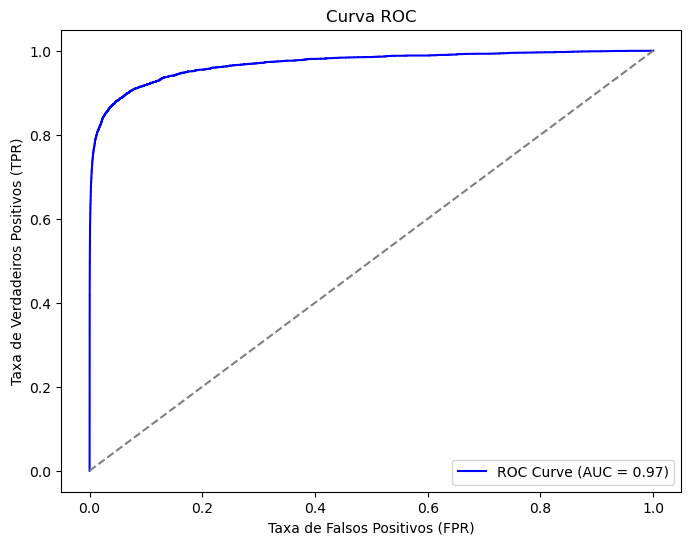

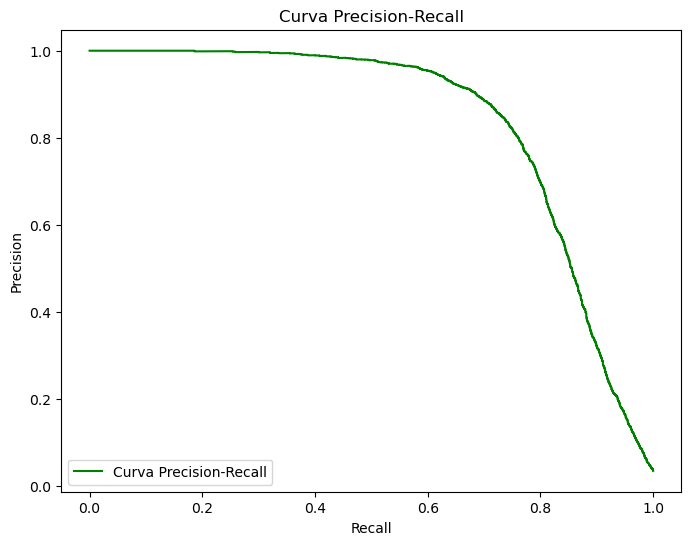

In [21]:
# Fazer previsões nos dados de validação
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]  # Probabilidade da classe positiva

# Gerar a Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_valid, y_valid_proba)
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.savefig('images/curva_roc_model_2.png')  # Salvar o gráfico
plt.show()

# Gerar a Curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_valid, y_valid_proba)

# Plotar a Curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Curva Precision-Recall')
plt.title('Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.savefig('images/precision-recall_curve_model_2.png')  # Salvar o gráfico
plt.show()

In [34]:
# Verifique se as variáveis são arrays e calcule a média
precision_avg = precision.mean() if isinstance(precision, np.ndarray) else precision
recall_avg = recall.mean() if isinstance(recall, np.ndarray) else recall
f1_avg = f1.mean() if isinstance(f1, np.ndarray) else f1

precision_test_avg = precision_test.mean() if isinstance(precision_test, np.ndarray) else precision_test
recall_test_avg = recall_test.mean() if isinstance(recall_test, np.ndarray) else recall_test
f1_test_avg = f1_test.mean() if isinstance(f1_test, np.ndarray) else f1_test

# Agora os valores estão corretos para formatação
print(f"Comparação de Precisão: Validação = {precision_avg:.4f}, Teste = {precision_test_avg:.4f}")
print(f"Comparação de Recall: Validação = {recall_avg:.4f}, Teste = {recall_test_avg:.4f}")
print(f"Comparação de F1-Score: Validação = {f1_avg:.4f}, Teste = {f1_test_avg:.4f}")

Comparação de Precisão: Validação = 0.1414, Teste = 0.8510
Comparação de Recall: Validação = 0.9529, Teste = 0.7546
Comparação de F1-Score: Validação = 0.7863, Teste = 0.7999


In [35]:
# Calcular AUC no conjunto de teste
auc_test = roc_auc_score(y_test, y_test_proba)
print(f"AUC (Teste): {auc_test:.4f}")

AUC (Teste): 0.9718


In [22]:
feature_names = X_test.columns

In [23]:
# Verificar se todas as colunas estão no formato numérico
print(X_train_res.dtypes)
print(X_valid.dtypes)
print(X_test.dtypes)

TransactionDT                         float32
TransactionAmt                        float32
ProductCD                               int16
card1                                 float32
card2                                 float32
                                       ...   
D11_card1_std                         float32
D11_card1_addr1_mean                  float32
D11_card1_addr1_std                   float32
D11_card1_addr1_P_emaildomain_mean    float32
D11_card1_addr1_P_emaildomain_std     float32
Length: 241, dtype: object
TransactionDT                         float32
TransactionAmt                        float32
ProductCD                               int16
card1                                 float32
card2                                 float32
                                       ...   
D11_card1_std                         float32
D11_card1_addr1_mean                  float32
D11_card1_addr1_std                   float32
D11_card1_addr1_P_emaildomain_mean    float32
D11_car

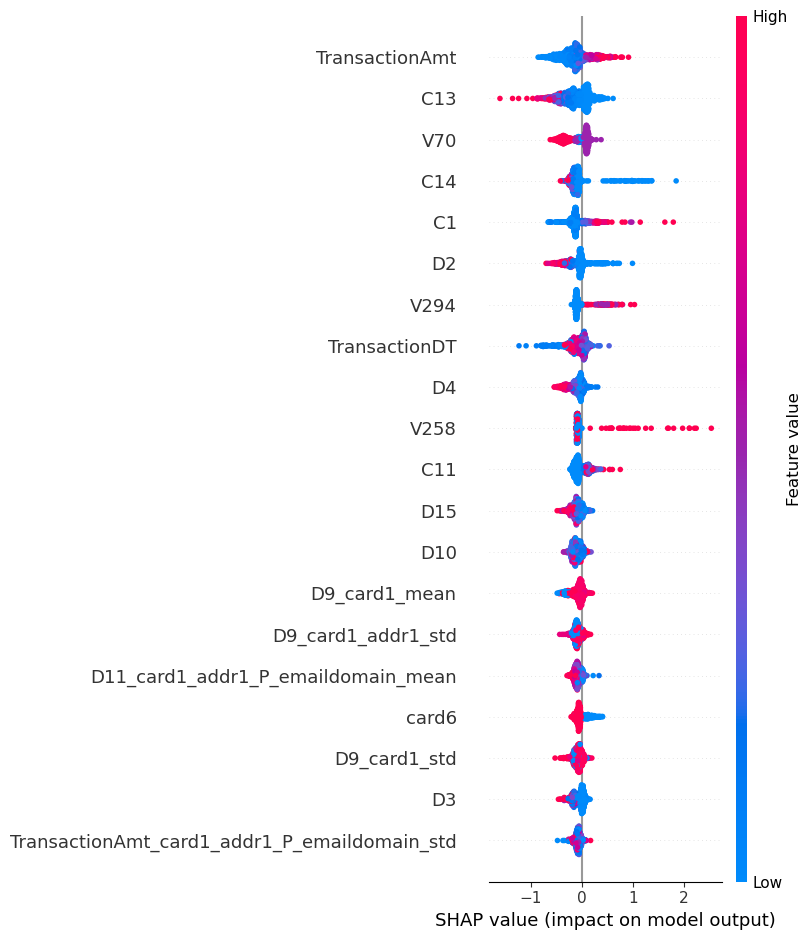

CPU times: user 18min 34s, sys: 344 ms, total: 18min 35s
Wall time: 2min 42s


In [30]:
%%time
import shap

# Usar TreeExplainer para XGBoost
explainer = shap.TreeExplainer(best_model)

# Subamostrar 1000 linhas do X_test para calcular os valores SHAP
sample_size = 1000
X_test_sample = X_test.sample(n=sample_size, random_state=SEED)

# Calcular os valores SHAP apenas para a amostra
shap_values_sample = explainer.shap_values(X_test_sample)

# Criar uma nova figura para o gráfico de resumo SHAP
plt.figure()

# Gerar o gráfico SHAP com as 20 features mais importantes para a amostra
shap.summary_plot(shap_values_sample, X_test_sample, feature_names=feature_names, max_display=20, show=False)

# Salvar o gráfico gerado
plt.savefig("shap_summary_plot.png", format='png', dpi=300)

# Exibir o gráfico no notebook
plt.show()

# Fechar a plotagem para evitar conflitos com o Jupyter Notebook
plt.close()

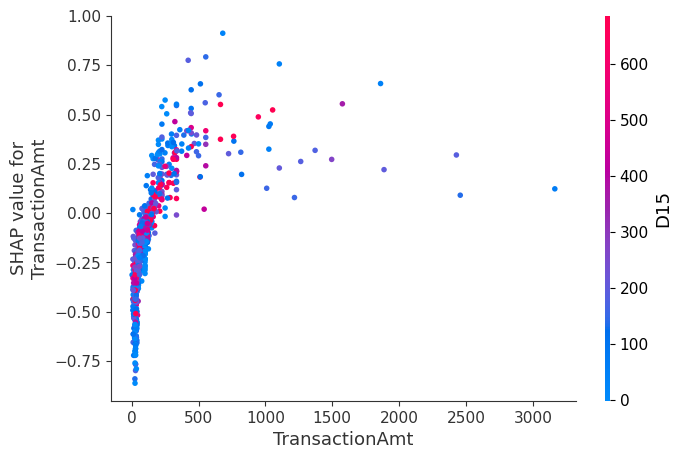

In [31]:
# Gráfico de dependência SHAP para uma feature específica
shap.dependence_plot('TransactionAmt', shap_values_sample, X_test_sample, show=False)

# Salvar o gráfico gerado
plt.savefig("shap_dependence_plot_TransactionAmt.png", format='png', dpi=300)

# Exibir o gráfico no notebook
plt.show()

# Fechar a plotagem para evitar conflitos com o Jupyter Notebook
plt.close()